<a href="https://colab.research.google.com/github/GhazaleZe/A-voting-system-with-Atmega32/blob/master/outlierRandomForestCompAss4_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U -q PyDrive 

In [88]:
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
import numpy as np


def reading_data():
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  #F-F Research data factors
  file_id = '1JqjCLhMszamzs3_ihpqCVFskcZYicXYy' 


  download = drive.CreateFile({'id': file_id})

  #F-F Research data factors daily

  file_id_d = '1In0NkXHqz-QRlfivTTDaAbE2QFCrzZt6' 


  download_daily = drive.CreateFile({'id': file_id_d})

  # predicator 

  file_id_p = '1yyVF3ilhlD-GDc08BL2k_VJfLiUsbpEF'
  
  ## reading data
  download_predictor = drive.CreateFile({'id': file_id_p})
  download.GetContentFile('F-F_Research_Data_Factors.CSV')
  FF_monthly_df  = pd.read_csv("F-F_Research_Data_Factors.CSV")
  FF_monthly_df = FF_monthly_df [FF_monthly_df['Year_Month']>='192701']
  FF_monthly_df= FF_monthly_df.dropna()
  FF_monthly_df['Year_Month'] = FF_monthly_df['Year_Month'].astype(int)
  FF_monthly_df = FF_monthly_df [(FF_monthly_df['Year_Month']>=192701) & (FF_monthly_df['Year_Month']<202201)]
  FF_monthly_df['Year_Month'] = FF_monthly_df['Year_Month'].astype(str)
  FF_monthly_df.sort_values('Year_Month', ascending=True)

  FF_monthly_df['Mkt-RF']= FF_monthly_df['Mkt-RF'].astype(float)/100
  FF_monthly_df['RF']= FF_monthly_df['RF'].astype(float)/100

  download_daily.GetContentFile('F-F_Research_Data_Factors_daily.CSV')

  FF_daily_df  = pd.read_csv("F-F_Research_Data_Factors_daily.CSV")
  FF_daily_df = FF_daily_df.dropna()
  FF_daily_df['Mkt-RF']= FF_daily_df['Mkt-RF'].astype(float)/100
  FF_daily_df['RF']= FF_daily_df['RF'].astype(float)/100
  FF_daily_df['MKt'] = FF_daily_df['Mkt-RF'] + FF_daily_df['RF']
  #FF_daily_df['YYMMDD'] = FF_daily_df['YYMMDD'].astype(int)
  FF_daily_df = FF_daily_df [(FF_daily_df['YYMMDD']>= '19270101') & (FF_daily_df['YYMMDD'] <= '20211231')]

  download_predictor.GetContentFile('PredictorData2021Monthly.csv')
  Predictore_df  = pd.read_csv("PredictorData2021Monthly.csv")

  Predictore_df = Predictore_df[Predictore_df['yyyymm']>=192701]
  # delete column csp
  Predictore_df = Predictore_df.drop('csp' , axis=1)

  return FF_daily_df, FF_monthly_df, Predictore_df



FF_daily_df, FF_monthly_df, Predictore_df = reading_data()


FF_daily_df


,YYMMDD,Mkt-RF,SMB,HML,RF,MKt
150,19270103,-0.0079,0.19,0.09,0.0001,-0.0078
151,19270104,0.0031,0.14,-0.66,0.0001,0.0032
152,19270105,0.0014,0.46,-0.36,0.0001,0.0015
153,19270106,-0.0017,-0.05,0.15,0.0001,-0.0016
154,19270107,0.0030,-0.23,0.41,0.0001,0.0031
...,...,...,...,...,...,...
25143,20211227,0.0122,-0.11,0.29,0.0000,0.0122
25144,20211228,-0.0027,-0.60,0.81,0.0000,-0.0027
25145,20211229,0.0006,-0.07,0.17,0.0000,0.0006
25146,20211230,-0.0015,0.10,-0.40,0.0000,-0.0015


# Random Forest Starts here

In [89]:
pre_df = pd.read_csv("predictor.csv")
pre_df = pre_df.drop('Unnamed: 0' , axis=1)
pre_df['Year_Month']= pre_df['Year_Month'].astype(str)
pre_df

,Year_Month,d/p,e/p,bm,ntis,tbl,ltr,dfy,tms,infl,corpr,svar,lag_ex_ret
0,192701,-2.942374,-2.374773,0.443706,0.050824,0.0323,0.0075,0.0095,-0.0248,-0.011299,0.0056,0.000470,0.013779
1,192702,-2.979535,-2.430353,0.428501,0.051668,0.0329,0.0088,0.0092,-0.0241,-0.005714,0.0069,0.000287,-0.023256
2,192703,-2.976535,-2.445079,0.469765,0.046357,0.0320,0.0253,0.0092,-0.0067,-0.005747,0.0083,0.000924,0.045091
3,192704,-2.984225,-2.471309,0.456754,0.050514,0.0339,-0.0005,0.0090,-0.0344,0.000000,0.0055,0.000603,0.003503
4,192705,-3.025963,-2.531446,0.434783,0.055275,0.0333,0.0109,0.0093,-0.0224,0.005780,-0.0011,0.000392,0.014729
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,202108,-4.342866,-3.282043,0.184756,0.014846,0.0005,-0.0035,0.0069,-0.0040,0.002066,-0.0045,0.000602,0.022748
1136,202109,-4.286281,-3.201224,0.193036,0.015598,0.0004,-0.0250,0.0070,-0.0254,0.002716,-0.0194,0.001393,0.028990
1137,202110,-4.346731,-3.226260,0.182389,0.013368,0.0005,0.0051,0.0067,0.0046,0.008308,0.0159,0.001151,-0.047569
1138,202111,-4.331997,-3.177747,0.189455,0.015640,0.0005,0.0210,0.0066,0.0205,0.004913,0.0094,0.001327,0.069144


## Can month separately be one of the factors?

In [90]:
Predictore_df = pd.merge(pre_df,FF_monthly_df, left_on='Year_Month', right_on='Year_Month', how='inner')


Predictore_df = Predictore_df.drop(['SMB','HML','RF'] , axis=1)
Predictore_df['lag_ex_ret'] = Predictore_df['Mkt-RF'].shift(1)
Predictore_df = Predictore_df.dropna()




Predictore_df

,Year_Month,d/p,e/p,bm,ntis,tbl,ltr,dfy,tms,infl,corpr,svar,lag_ex_ret,Mkt-RF
1,192702,-2.979535,-2.430353,0.428501,0.051668,0.0329,0.0088,0.0092,-0.0241,-0.005714,0.0069,0.000287,-0.0006,0.0418
2,192703,-2.976535,-2.445079,0.469765,0.046357,0.0320,0.0253,0.0092,-0.0067,-0.005747,0.0083,0.000924,0.0418,0.0013
3,192704,-2.984225,-2.471309,0.456754,0.050514,0.0339,-0.0005,0.0090,-0.0344,0.000000,0.0055,0.000603,0.0013,0.0046
4,192705,-3.025963,-2.531446,0.434783,0.055275,0.0333,0.0109,0.0093,-0.0224,0.005780,-0.0011,0.000392,0.0046,0.0544
5,192706,-3.007309,-2.531330,0.452385,0.058822,0.0307,-0.0069,0.0097,-0.0376,0.011494,0.0043,0.000825,0.0544,-0.0234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,202108,-4.342866,-3.282043,0.184756,0.014846,0.0005,-0.0035,0.0069,-0.0040,0.002066,-0.0045,0.000602,0.0127,0.0291
1136,202109,-4.286281,-3.201224,0.193036,0.015598,0.0004,-0.0250,0.0070,-0.0254,0.002716,-0.0194,0.001393,0.0291,-0.0437
1137,202110,-4.346731,-3.226260,0.182389,0.013368,0.0005,0.0051,0.0067,0.0046,0.008308,0.0159,0.001151,-0.0437,0.0665
1138,202111,-4.331997,-3.177747,0.189455,0.015640,0.0005,0.0210,0.0066,0.0205,0.004913,0.0094,0.001327,0.0665,-0.0155


In [91]:
train_Predictore_df = Predictore_df[Predictore_df['Year_Month'] <'195801']
valid_Predictore_df = Predictore_df[(Predictore_df['Year_Month'] >= '195801') & (Predictore_df['Year_Month'] <'198901')]
test_Predictore_df = Predictore_df[Predictore_df['Year_Month'] >= '198901']
train_Predictore_df

,Year_Month,d/p,e/p,bm,ntis,tbl,ltr,dfy,tms,infl,corpr,svar,lag_ex_ret,Mkt-RF
1,192702,-2.979535,-2.430353,0.428501,0.051668,0.0329,0.0088,0.0092,-0.0241,-0.005714,0.0069,0.000287,-0.0006,0.0418
2,192703,-2.976535,-2.445079,0.469765,0.046357,0.0320,0.0253,0.0092,-0.0067,-0.005747,0.0083,0.000924,0.0418,0.0013
3,192704,-2.984225,-2.471309,0.456754,0.050514,0.0339,-0.0005,0.0090,-0.0344,0.000000,0.0055,0.000603,0.0013,0.0046
4,192705,-3.025963,-2.531446,0.434783,0.055275,0.0333,0.0109,0.0093,-0.0224,0.005780,-0.0011,0.000392,0.0046,0.0544
5,192706,-3.007309,-2.531330,0.452385,0.058822,0.0307,-0.0069,0.0097,-0.0376,0.011494,0.0043,0.000825,0.0544,-0.0234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,195708,-3.251924,-2.572209,0.588005,0.035854,0.0337,0.0002,0.0072,-0.0335,0.000000,-0.0009,0.002147,0.0066,-0.0511
368,195709,-3.182306,-2.503465,0.624151,0.034363,0.0353,0.0076,0.0081,-0.0277,0.000000,0.0095,0.001517,-0.0511,-0.0598
369,195710,-3.144055,-2.480523,0.645746,0.038410,0.0358,-0.0050,0.0089,-0.0408,0.000000,0.0023,0.004936,-0.0598,-0.0432
370,195711,-3.154367,-2.506235,0.633072,0.040990,0.0331,0.0533,0.0101,0.0202,0.003534,0.0311,0.003490,-0.0432,0.0230


## Max Feature test

In [12]:
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score


x_train = train_Predictore_df.iloc[:,:13]
#x_train = x_train.drop(['Year_Month','tms','bm'], axis=1)
x_train = x_train.drop(['Year_Month'], axis=1)
y_train = train_Predictore_df.iloc[:,13]

x_valid = valid_Predictore_df.iloc[:,:13]
#x_valid = x_valid.drop(['Year_Month','tms','bm'], axis=1)
x_valid = x_valid.drop(['Year_Month'], axis=1)
y_valid = valid_Predictore_df.iloc[:,13]
      

maxfeatures = list(range(3, 12,3))
maxfeatures.append(int(math.sqrt(len(x_train.columns))))
maxfeatures.append(int(math.log2(len(x_train.columns))))
dict_winner = {}
min_samples_split_list = [0.2,0.5,0.9]
best_min_samples_split_list=[]
estimator=[50,200,500]
for i in maxfeatures:
  best_depth = []
  for e in estimator:
    
    for j in min_samples_split_list:
      
      for k in range(1,20,3):
        regressor = RandomForestRegressor(n_estimators=e, max_depth = k,max_features=i,min_samples_split=j,random_state=42)
        regressor.fit(x_train, y_train)    
        y_pred = regressor.predict(x_valid)
              #mse = mean_squared_error(y_valid, y_pred)
        r2 = r2_score(y_valid, y_pred)
        best_depth.append([r2,j,k,e])
      
      
  dict_winner[i] = [max(best_depth)]

dict_winner

{3: [[0.06931779041066244, 0.5, 19, 50]],
 6: [[0.04330139996809923, 0.5, 1, 200]],
 9: [[0.044241912978375764, 0.5, 1, 200]]}

In [13]:
x_train

,d/p,e/p,bm,ntis,tbl,ltr,dfy,tms,infl,corpr,svar,lag_ex_ret
1,-2.979535,-2.430353,0.428501,0.051668,0.0329,0.0088,0.0092,-0.0241,-0.005714,0.0069,0.000287,-0.0006
2,-2.976535,-2.445079,0.469765,0.046357,0.0320,0.0253,0.0092,-0.0067,-0.005747,0.0083,0.000924,0.0418
3,-2.984225,-2.471309,0.456754,0.050514,0.0339,-0.0005,0.0090,-0.0344,0.000000,0.0055,0.000603,0.0013
4,-3.025963,-2.531446,0.434783,0.055275,0.0333,0.0109,0.0093,-0.0224,0.005780,-0.0011,0.000392,0.0046
5,-3.007309,-2.531330,0.452385,0.058822,0.0307,-0.0069,0.0097,-0.0376,0.011494,0.0043,0.000825,0.0544
...,...,...,...,...,...,...,...,...,...,...,...,...
367,-3.251924,-2.572209,0.588005,0.035854,0.0337,0.0002,0.0072,-0.0335,0.000000,-0.0009,0.002147,0.0066
368,-3.182306,-2.503465,0.624151,0.034363,0.0353,0.0076,0.0081,-0.0277,0.000000,0.0095,0.001517,-0.0511
369,-3.144055,-2.480523,0.645746,0.038410,0.0358,-0.0050,0.0089,-0.0408,0.000000,0.0023,0.004936,-0.0598
370,-3.154367,-2.506235,0.633072,0.040990,0.0331,0.0533,0.0101,0.0202,0.003534,0.0311,0.003490,-0.0432


Not for main code

In [ ]:
# X_train_df = Predictore_df[Predictore_df['Year_Month'] <'198901']

# test_Predictore_df = Predictore_df[Predictore_df['Year_Month'] >= '198901']
# x_train_larg = X_train_df.iloc[:,:13]
# #x_train_larg = x_train_larg.drop(['Year_Month','tms','bm'], axis=1)
# x_train_larg = x_train_larg.drop(['Year_Month'], axis=1)

# y_train_larg= X_train_df.iloc[:,13]
# test_Predictore_df =test_Predictore_df.dropna()

# x_test = test_Predictore_df.iloc[:,:13]
# #x_test = x_test.drop(['Year_Month','tms','bm'], axis=1)
# x_test = x_test.drop(['Year_Month'], axis=1)

# y_test = test_Predictore_df.iloc[:,13]
# r2_main_list = []
# for i in dict_winner:
#   regressor = RandomForestRegressor(n_estimators=dict_winner[i][0][3], max_depth = dict_winner[i][0][2],max_features=i,min_samples_split=dict_winner[i][0][1])
#   regressor.fit(x_train_larg, y_train_larg)    
#   y_pred_test = regressor.predict(x_test)

#   r2_main = r2_score(y_test, y_pred_test)
#   r2_main_list.append(r2_main)
# r2_main_list

[0.02967733076082968,
 0.022122380714796552,
 0.024872451996474032,
 0.02147010801729765,
 0.015023753036733312,
 0.029621944715930826,
 -0.0058524686392256164,
 -0.005835228076028098,
 0.029025681546823945]

# Adding one by one to train

In [92]:
X_train_df = Predictore_df[Predictore_df['Year_Month'] <'198901']

test_Predictore_df = Predictore_df[Predictore_df['Year_Month'] >= '198901']
x_train_larg = X_train_df.iloc[:,:13]
#x_train_larg = x_train_larg.drop(['Year_Month','tms','bm'], axis=1)
x_train_larg = x_train_larg.drop(['Year_Month'], axis=1)

y_train_larg= X_train_df.iloc[:,13]
test_Predictore_df =test_Predictore_df.dropna()

x_test = test_Predictore_df.iloc[:,:13]
#x_test = x_test.drop(['Year_Month','tms','bm'], axis=1)
x_test = x_test.drop(['Year_Month'], axis=1)



regressor = RandomForestRegressor(n_estimators=50, max_depth =19,max_features=3,min_samples_split=0.5,random_state=42)
regressor.fit(x_train_larg, y_train_larg)    
y_pred_all = regressor.predict(x_test)
y_pred_all.mean()

0.01233694900129816

In [93]:
X_train_df = Predictore_df[Predictore_df['Year_Month'] <'198901']

test_Predictore_df = Predictore_df[Predictore_df['Year_Month'] >= '198901']
x_train_larg = X_train_df.iloc[:,:13]
#x_train_larg = x_train_larg.drop(['Year_Month','tms','bm'], axis=1)
x_train_larg = x_train_larg.drop(['Year_Month'], axis=1)

y_train_larg= X_train_df.iloc[:,13]
test_Predictore_df =test_Predictore_df.dropna()

x_test = test_Predictore_df.iloc[:,:13]
#x_test = x_test.drop(['Year_Month','tms','bm'], axis=1)
x_test = x_test.drop(['Year_Month'], axis=1)

y_test = test_Predictore_df.iloc[:,13]
r2_adding_list = []
y_pred_test = []
for i in range(len(x_test)):
  regressor = RandomForestRegressor(n_estimators=50, max_depth =19,max_features=3,min_samples_split=0.5,random_state=42)
  regressor.fit(x_train_larg, y_train_larg)    
  y_pred_test_temp = regressor.predict((x_test.iloc[i:i+1,:]))

  y_pred_test.append(y_pred_test_temp)
  # r2_adding = r2_score(y_test, y_pred_test)
  # r2_adding_list.append(r2_adding)
  x_train_larg = pd.concat([x_train_larg,x_test.iloc[i:i+1,:]],ignore_index=True)
  #print(x_train_larg)
  s = pd.Series(y_test.iloc[i])
  y_train_larg = pd.concat([y_train_larg,s],ignore_index=True)
  #y_train_larg.columns = y_train_larg.columns.astype(str)

y_train_larg

0       0.0418
1       0.0013
2       0.0046
3       0.0544
4      -0.0234
         ...  
1134    0.0291
1135   -0.0437
1136    0.0665
1137   -0.0155
1138    0.0310
Length: 1139, dtype: float64

In [94]:
y_pred_test

[array([0.01291836]),
 array([-0.00492853]),
 array([0.00883178]),
 array([0.01164714]),
 array([0.01705445]),
 array([0.02067346]),
 array([0.0210679]),
 array([-0.00732599]),
 array([0.00749938]),
 array([0.01228253]),
 array([0.00953472]),
 array([0.00561651]),
 array([-0.00748699]),
 array([-6.41825027e-05]),
 array([0.00015387]),
 array([-0.00817703]),
 array([0.01961382]),
 array([0.01588859]),
 array([0.01255678]),
 array([-0.01466629]),
 array([0.0100179]),
 array([0.00839668]),
 array([0.01662791]),
 array([0.01273317]),
 array([0.01247437]),
 array([0.01325869]),
 array([0.01243341]),
 array([0.01603808]),
 array([0.01220172]),
 array([0.00380733]),
 array([0.01567975]),
 array([0.01749308]),
 array([0.01771622]),
 array([0.01378301]),
 array([0.01312776]),
 array([0.02846816]),
 array([0.00234741]),
 array([0.02278196]),
 array([0.00753459]),
 array([0.01423298]),
 array([0.01897991]),
 array([0.01665073]),
 array([0.01771233]),
 array([0.01278119]),
 array([0.01331435]),
 a

In [97]:
print(len(y_pred_test))
pd.Series(y_pred_test).mean()

396


array([0.00866765])

## Accuracy

In [98]:
y_pred_test
y_pred_test_s = []
for k in range(len(y_pred_test)):
  y_pred_test_s.append(y_pred_test[k][0])
y_test = y_test.reset_index(drop=True)
y_test_MKT = y_test
y_pred_test_s = pd.Series(y_pred_test_s)
def calculate_r2(actual_values, forecast_values):
    numerator = sum([(forecast_values[i] - actual_values[i])**2 for i in range(len(actual_values))])
    denominator = sum([(actual_values.mean() - actual_values[i])**2 for i in range(len(actual_values))])
    r2 = 1 - (numerator / denominator)
    return r2

calculate_r2(y_test_MKT,y_pred_test_s)


0.06357305499353916

<Axes: >

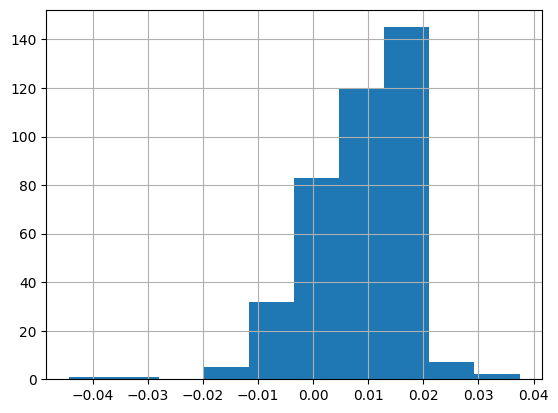

In [100]:
y_pred_test_s.hist()

<Axes: >

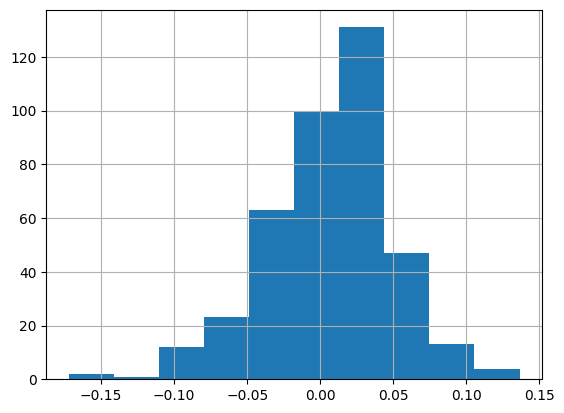

In [101]:
y_test_MKT.hist()

In [19]:
y_test

0      0.0610
1     -0.0225
2      0.0157
3      0.0433
4      0.0335
        ...  
391    0.0291
392   -0.0437
393    0.0665
394   -0.0155
395    0.0310
Name: Mkt-RF, Length: 396, dtype: float64

In [102]:
x_test_added = x_test
x_test_added['MKt-RF']  = y_test.values
# x_test_added  = pd.concat([x_test_added ,y_pred_test_s],ignore_index=True)
x_test_added['MKt-RF_predicted']  = y_pred_test_s.values
x_test_added.to_csv("total.csv",index=False)
x_test_added

,d/p,e/p,bm,ntis,tbl,ltr,dfy,tms,infl,corpr,svar,lag_ex_ret,MKt-RF,MKt-RF_predicted
744,-3.409163,-2.510892,0.430769,-0.022361,0.0827,0.0203,0.0103,-0.0624,0.004979,0.0202,0.000965,0.0149,0.0610,0.012918
745,-3.370986,-2.464957,0.446778,-0.024823,0.0853,-0.0179,0.0097,-0.1032,0.004129,-0.0129,0.001176,0.0610,-0.0225,-0.004929
746,-3.382850,-2.469260,0.468691,-0.023102,0.0882,0.0122,0.0087,-0.0760,0.005757,0.0064,0.001286,-0.0225,0.0157,0.008832
747,-3.419909,-2.514668,0.444435,-0.022802,0.0865,0.0159,0.0082,-0.0706,0.006541,0.0213,0.000956,0.0157,0.0433,0.011647
748,-3.442765,-2.545751,0.433442,-0.027714,0.0843,0.0401,0.0089,-0.0442,0.005686,0.0379,0.001073,0.0433,0.0335,0.017054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,-4.342866,-3.282043,0.184756,0.014846,0.0005,-0.0035,0.0069,-0.0040,0.002066,-0.0045,0.000602,0.0127,0.0291,0.006688
1136,-4.286281,-3.201224,0.193036,0.015598,0.0004,-0.0250,0.0070,-0.0254,0.002716,-0.0194,0.001393,0.0291,-0.0437,0.005482
1137,-4.346731,-3.226260,0.182389,0.013368,0.0005,0.0051,0.0067,0.0046,0.008308,0.0159,0.001151,-0.0437,0.0665,0.014995
1138,-4.331997,-3.177747,0.189455,0.015640,0.0005,0.0210,0.0066,0.0205,0.004913,0.0094,0.001327,0.0665,-0.0155,0.013720


In [103]:
def calculate_directional_accuracy(actual_values, forecast_values):
    correct_direction = 0
    for i in range(1, len(actual_values)):
        if (actual_values[i] - actual_values[i-1]) * (forecast_values[i] - actual_values[i-1]) > 0:
            correct_direction += 1
    directional_accuracy = correct_direction / (len(actual_values)-1)
    return directional_accuracy
calculate_directional_accuracy(y_test_MKT,y_pred_test_s)

0.7341772151898734

In [104]:
len(y_pred_test_s)

396

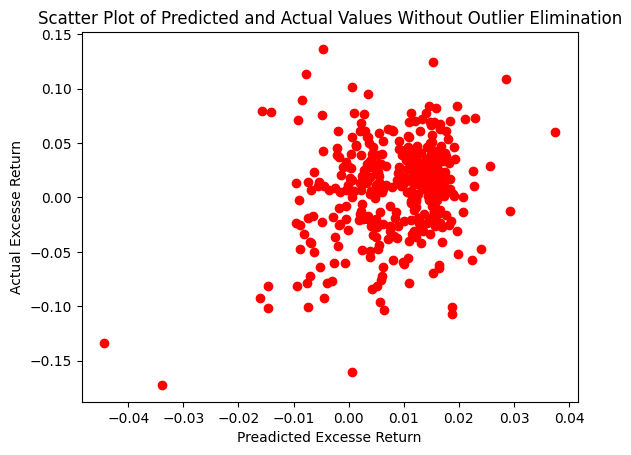

In [105]:
import matplotlib.pyplot as plt
#temp = Predictore_df[Predictore_df['Year_Month'] >= '198901']
#x = temp['Year_Month']
#plt.scatter(x, y_pred_test_s, color='blue')
plt.scatter(y_pred_test_s, y_test_MKT, color='r')
plt.xlabel('Preadicted Excesse Return')
plt.ylabel('Actual Excesse Return')
plt.title('Scatter Plot of Predicted and Actual Values Without Outlier Elimination')
plt.show()

# Volatility Random Forest

In [106]:
def extract_monthly_volitility_mean(FF_daily_df):
  df_volitility_daily = pd.DataFrame(columns=['YYYYMM', 'Volatility','SD'])
  #def volatility_from_daily(df):
  year_index = np.arange(1927, 2022, 1)
  month_index = [f'{i:02}' for i in range(1, 13)]
  FF_daily_df['year'] = FF_daily_df['YYMMDD'].str[:4]
  FF_daily_df['month'] = FF_daily_df['YYMMDD'].str[4:6]
  FF_daily_df['day'] = FF_daily_df['YYMMDD'].str[6:]
  mean_list =[]
  #FF_daily_df.head(50)
  for year in year_index:
    for month in month_index:
      sub_set_daily = FF_daily_df[(FF_daily_df['year']==str(year)) & (FF_daily_df['month']==str(month))]
      subset_copy1 = sub_set_daily.copy()
      subset_copy1['Mkt-RF'] = subset_copy1['Mkt-RF'] - (subset_copy1['Mkt-RF'].mean())
      #print (subset_copy1['Mkt-RF'].mean())
      mean_list.append(subset_copy1['Mkt-RF'].mean())
      sub_set_daily = subset_copy1

      subset_copy = sub_set_daily.copy()
      subset_copy['Mkt-RF'] = subset_copy['Mkt-RF'].astype(float).apply(lambda x: x**2)
      sub_set_daily = subset_copy
      new_index = len(df_volitility_daily) 
      #if month == '12':
        #df_volitility_daily.loc[new_index] = [str(year+1)+'01', sub_set_daily['Mkt-RF'].sum(), np.sqrt(sub_set_daily['Mkt-RF'].sum()/len(sub_set_daily['Mkt-RF']))]
      if month <'10':
        df_volitility_daily.loc[new_index] = [str(year)+ '0' +str(int(month)), sub_set_daily['Mkt-RF'].sum(), np.sqrt(sub_set_daily['Mkt-RF'].sum()/len(sub_set_daily['Mkt-RF']))]
      else:
        df_volitility_daily.loc[new_index] = [str(year)+str(int(month)), sub_set_daily['Mkt-RF'].sum(),round(np.sqrt(sub_set_daily['Mkt-RF'].sum()/len(sub_set_daily['Mkt-RF'])),3)]

  df_volitility_daily.to_csv('volitility_daily_mean.csv', index=False)
  print("this is mean of means :", np.mean(mean_list))
  return df_volitility_daily

df_volitility_RF = extract_monthly_volitility_mean(FF_daily_df)
df_volitility_RF

this is mean of means : 1.0427901240335537e-20


,YYYYMM,Volatility,SD
0,192701,0.000414,0.004067
1,192702,0.000138,0.002505
2,192703,0.000851,0.005615
3,192704,0.000575,0.004797
4,192705,0.000232,0.003045
...,...,...,...
1135,202108,0.000649,0.005432
1136,202109,0.001382,0.008111
1137,202110,0.001062,0.007000
1138,202111,0.001400,0.008000


In [107]:
df_volitility_RF = df_volitility_RF.drop('SD',axis=1)
RF_Voli_df = pd.merge(Predictore_df,df_volitility_RF, left_on='Year_Month', right_on='YYYYMM', how='inner')
RF_Voli_df= RF_Voli_df.drop(['YYYYMM','Mkt-RF'],axis =1)
RF_Voli_df

,Year_Month,d/p,e/p,bm,ntis,tbl,ltr,dfy,tms,infl,corpr,svar,lag_ex_ret,Volatility
0,192702,-2.979535,-2.430353,0.428501,0.051668,0.0329,0.0088,0.0092,-0.0241,-0.005714,0.0069,0.000287,-0.0006,0.000138
1,192703,-2.976535,-2.445079,0.469765,0.046357,0.0320,0.0253,0.0092,-0.0067,-0.005747,0.0083,0.000924,0.0418,0.000851
2,192704,-2.984225,-2.471309,0.456754,0.050514,0.0339,-0.0005,0.0090,-0.0344,0.000000,0.0055,0.000603,0.0013,0.000575
3,192705,-3.025963,-2.531446,0.434783,0.055275,0.0333,0.0109,0.0093,-0.0224,0.005780,-0.0011,0.000392,0.0046,0.000232
4,192706,-3.007309,-2.531330,0.452385,0.058822,0.0307,-0.0069,0.0097,-0.0376,0.011494,0.0043,0.000825,0.0544,0.000739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1134,202108,-4.342866,-3.282043,0.184756,0.014846,0.0005,-0.0035,0.0069,-0.0040,0.002066,-0.0045,0.000602,0.0127,0.000649
1135,202109,-4.286281,-3.201224,0.193036,0.015598,0.0004,-0.0250,0.0070,-0.0254,0.002716,-0.0194,0.001393,0.0291,0.001382
1136,202110,-4.346731,-3.226260,0.182389,0.013368,0.0005,0.0051,0.0067,0.0046,0.008308,0.0159,0.001151,-0.0437,0.001062
1137,202111,-4.331997,-3.177747,0.189455,0.015640,0.0005,0.0210,0.0066,0.0205,0.004913,0.0094,0.001327,0.0665,0.001400


In [108]:
RF_Voli_df ['Vol_1'] = RF_Voli_df['Volatility'].shift(1)
RF_Voli_df ['Vol_2'] = RF_Voli_df['Volatility'].shift(2)
RF_Voli_df ['Vol_3'] = RF_Voli_df['Volatility'].shift(3)
RF_Voli_df ['main_volatility'] = RF_Voli_df['Volatility'].shift(0)
RF_Voli_df = RF_Voli_df.drop('Volatility',axis=1).dropna()
RF_Voli_df

,Year_Month,d/p,e/p,bm,ntis,tbl,ltr,dfy,tms,infl,corpr,svar,lag_ex_ret,Vol_1,Vol_2,Vol_3,main_volatility
3,192705,-3.025963,-2.531446,0.434783,0.055275,0.0333,0.0109,0.0093,-0.0224,0.005780,-0.0011,0.000392,0.0046,0.000575,0.000851,0.000138,0.000232
4,192706,-3.007309,-2.531330,0.452385,0.058822,0.0307,-0.0069,0.0097,-0.0376,0.011494,0.0043,0.000825,0.0544,0.000232,0.000575,0.000851,0.000739
5,192707,-3.061144,-2.603707,0.414553,0.059750,0.0296,0.0050,0.0095,-0.0246,-0.017045,0.0003,0.000426,-0.0234,0.000739,0.000232,0.000575,0.000159
6,192708,-3.095764,-2.656742,0.396227,0.054522,0.0270,0.0076,0.0092,-0.0194,-0.005780,0.0083,0.001276,0.0726,0.000159,0.000739,0.000232,0.001126
7,192709,-3.129097,-2.707759,0.380586,0.094613,0.0268,0.0018,0.0088,-0.0250,0.005814,0.0149,0.001123,0.0197,0.001126,0.000159,0.000739,0.000905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1134,202108,-4.342866,-3.282043,0.184756,0.014846,0.0005,-0.0035,0.0069,-0.0040,0.002066,-0.0045,0.000602,0.0127,0.001182,0.000576,0.001714,0.000649
1135,202109,-4.286281,-3.201224,0.193036,0.015598,0.0004,-0.0250,0.0070,-0.0254,0.002716,-0.0194,0.001393,0.0291,0.000649,0.001182,0.000576,0.001382
1136,202110,-4.346731,-3.226260,0.182389,0.013368,0.0005,0.0051,0.0067,0.0046,0.008308,0.0159,0.001151,-0.0437,0.001382,0.000649,0.001182,0.001062
1137,202111,-4.331997,-3.177747,0.189455,0.015640,0.0005,0.0210,0.0066,0.0205,0.004913,0.0094,0.001327,0.0665,0.001062,0.001382,0.000649,0.001400


In [109]:
train_Predictore_df = RF_Voli_df[RF_Voli_df['Year_Month'] <'195801']
valid_Predictore_df = RF_Voli_df[(RF_Voli_df['Year_Month'] >= '195801') & (RF_Voli_df['Year_Month'] <'198901')]
test_Predictore_df = RF_Voli_df[RF_Voli_df['Year_Month'] >= '198901']
train_Predictore_df

,Year_Month,d/p,e/p,bm,ntis,tbl,ltr,dfy,tms,infl,corpr,svar,lag_ex_ret,Vol_1,Vol_2,Vol_3,main_volatility
3,192705,-3.025963,-2.531446,0.434783,0.055275,0.0333,0.0109,0.0093,-0.0224,0.005780,-0.0011,0.000392,0.0046,0.000575,0.000851,0.000138,0.000232
4,192706,-3.007309,-2.531330,0.452385,0.058822,0.0307,-0.0069,0.0097,-0.0376,0.011494,0.0043,0.000825,0.0544,0.000232,0.000575,0.000851,0.000739
5,192707,-3.061144,-2.603707,0.414553,0.059750,0.0296,0.0050,0.0095,-0.0246,-0.017045,0.0003,0.000426,-0.0234,0.000739,0.000232,0.000575,0.000159
6,192708,-3.095764,-2.656742,0.396227,0.054522,0.0270,0.0076,0.0092,-0.0194,-0.005780,0.0083,0.001276,0.0726,0.000159,0.000739,0.000232,0.001126
7,192709,-3.129097,-2.707759,0.380586,0.094613,0.0268,0.0018,0.0088,-0.0250,0.005814,0.0149,0.001123,0.0197,0.001126,0.000159,0.000739,0.000905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366,195708,-3.251924,-2.572209,0.588005,0.035854,0.0337,0.0002,0.0072,-0.0335,0.000000,-0.0009,0.002147,0.0066,0.000500,0.000540,0.000365,0.001870
367,195709,-3.182306,-2.503465,0.624151,0.034363,0.0353,0.0076,0.0081,-0.0277,0.000000,0.0095,0.001517,-0.0511,0.001870,0.000500,0.000540,0.001267
368,195710,-3.144055,-2.480523,0.645746,0.038410,0.0358,-0.0050,0.0089,-0.0408,0.000000,0.0023,0.004936,-0.0598,0.001267,0.001870,0.000500,0.004830
369,195711,-3.154367,-2.506235,0.633072,0.040990,0.0331,0.0533,0.0101,0.0202,0.003534,0.0311,0.003490,-0.0432,0.004830,0.001267,0.001870,0.003292


In [29]:
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score


x_train = train_Predictore_df.iloc[:,:16]
#x_train = x_train.drop(['Year_Month','tms','bm'], axis=1)
x_train = x_train.drop(['Year_Month'], axis=1)
y_train = train_Predictore_df.iloc[:,16]

x_valid = valid_Predictore_df.iloc[:,:16]
#x_valid = x_valid.drop(['Year_Month','tms','bm'], axis=1)
x_valid = x_valid.drop(['Year_Month'], axis=1)
y_valid = valid_Predictore_df.iloc[:,16]
      

maxfeatures = list(range(3, 14,3))
maxfeatures.append(int(math.sqrt(len(x_train.columns))))
maxfeatures.append(int(math.log2(len(x_train.columns))))
dict_winner = {}
min_samples_split_list = [0.2,0.5,0.9]
best_min_samples_split_list=[]
estimator=[50,200,500]
for i in maxfeatures:
  best_depth = []
  for e in estimator:
    
    for j in min_samples_split_list:
      
      for k in range(1,20,3):
        regressor = RandomForestRegressor(n_estimators=e, max_depth = k,max_features=i,min_samples_split=j,random_state=42)
        regressor.fit(x_train, y_train)    
        y_pred = regressor.predict(x_valid)
              #mse = mean_squared_error(y_valid, y_pred)
        r2 = r2_score(y_valid, y_pred)
        best_depth.append([r2,j,k,e])
      
      
  dict_winner[i] = [max(best_depth)]

dict_winner

{3: [[0.2614981074229905, 0.2, 4, 500]],
 6: [[0.5334863784472768, 0.2, 10, 200]],
 9: [[0.6762877683532158, 0.2, 19, 50]],
 12: [[0.7413337387875386, 0.2, 19, 50]]}

In [ ]:
# X_train_df = RF_Voli_df[RF_Voli_df['Year_Month'] <'198901']

# test_Predictore_df = RF_Voli_df[RF_Voli_df['Year_Month'] >= '198901']
# x_train_larg = X_train_df.iloc[:,:16]
# #x_train_larg = x_train_larg.drop(['Year_Month','tms','bm'], axis=1)
# x_train_larg = x_train_larg.drop(['Year_Month'], axis=1)

# y_train_larg= X_train_df.iloc[:,16]
# test_Predictore_df =test_Predictore_df.dropna()

# x_test = test_Predictore_df.iloc[:,:16]
# #x_test = x_test.drop(['Year_Month','tms','bm'], axis=1)
# x_test = x_test.drop(['Year_Month'], axis=1)

# y_test = test_Predictore_df.iloc[:,16]
# r2_main_list = []
# for i in dict_winner:
#   regressor = RandomForestRegressor(n_estimators=dict_winner[i][0][3], max_depth = dict_winner[i][0][2],max_features=i,min_samples_split=dict_winner[i][0][1])
#   regressor.fit(x_train_larg, y_train_larg)    
#   y_pred_test = regressor.predict(x_test)

#   r2_main = r2_score(y_test, y_pred_test)
#   r2_main_list.append(r2_main)
# r2_main_list

# RandomForest Portfolio

In [110]:
X_train_df = RF_Voli_df[RF_Voli_df['Year_Month'] <'198901']

test_Predictore_df = RF_Voli_df[RF_Voli_df['Year_Month'] >= '198901']
x_train_larg = X_train_df.iloc[:,:16]
#x_train_larg = x_train_larg.drop(['Year_Month','tms','bm'], axis=1)
x_train_larg = x_train_larg.drop(['Year_Month'], axis=1)

y_train_larg= X_train_df.iloc[:,16]
test_Predictore_df =test_Predictore_df.dropna()

x_test = test_Predictore_df.iloc[:,:16]
#x_test = x_test.drop(['Year_Month','tms','bm'], axis=1)
x_test = x_test.drop(['Year_Month'], axis=1)

y_test = test_Predictore_df.iloc[:,16]

r2_adding_list = []
y_pred_test_voli = []
for i in range(len(x_test)):
  regressor = RandomForestRegressor(n_estimators=50, max_depth = 19,max_features=12,min_samples_split=0.2,random_state=42)
  regressor.fit(x_train_larg, y_train_larg)    
  y_pred_test_temp_voli = regressor.predict((x_test.iloc[i:i+1,:]))

  y_pred_test_voli.append(y_pred_test_temp_voli)
  # r2_adding = r2_score(y_test, y_pred_test)
  # r2_adding_list.append(r2_adding)
  x_train_larg = pd.concat([x_train_larg,x_test.iloc[i:i+1,:]],ignore_index=True)
  #print(x_train_larg)
  s = pd.Series(y_test.iloc[i])
  y_train_larg = pd.concat([y_train_larg,s],ignore_index=True)
  #y_train_larg.columns = y_train_larg.columns.astype(str)

y_train_larg

0       0.000232
1       0.000739
2       0.000159
3       0.001126
4       0.000905
          ...   
1131    0.000649
1132    0.001382
1133    0.001062
1134    0.001400
1135    0.002921
Length: 1136, dtype: float64

In [111]:
y_pred_test_voli

[array([0.00082373]),
 array([0.00090565]),
 array([0.00090787]),
 array([0.00081505]),
 array([0.00087816]),
 array([0.00099411]),
 array([0.00081245]),
 array([0.00092724]),
 array([0.00046711]),
 array([0.00540282]),
 array([0.00130417]),
 array([0.00084801]),
 array([0.00200468]),
 array([0.00092278]),
 array([0.00084176]),
 array([0.0007892]),
 array([0.00096451]),
 array([0.00093882]),
 array([0.00091964]),
 array([0.00529444]),
 array([0.00208257]),
 array([0.00407912]),
 array([0.00198935]),
 array([0.0009387]),
 array([0.00221711]),
 array([0.00193243]),
 array([0.00101884]),
 array([0.00172829]),
 array([0.00129366]),
 array([0.0009171]),
 array([0.00088043]),
 array([0.0017266]),
 array([0.00057579]),
 array([0.00085728]),
 array([0.00178524]),
 array([0.00181146]),
 array([0.00077868]),
 array([0.00074307]),
 array([0.00040695]),
 array([0.00146006]),
 array([0.00053388]),
 array([0.00070923]),
 array([0.00076087]),
 array([0.00039051]),
 array([0.000719]),
 array([0.000767

In [73]:
Mkt_s = pd.Series(y_pred_test)
Mkt_s[0]

array([0.01291836])

In [112]:


y_pred_test_voli_s = []
for k in range(len(y_pred_test_voli)):
  y_pred_test_voli_s.append(y_pred_test_voli[k][0])
y_test_voli = y_test.reset_index(drop=True)
def calculate_r2(actual_values, forecast_values):
    numerator = sum([(forecast_values[i] - actual_values[i])**2 for i in range(len(actual_values))])
    denominator = sum([(actual_values.mean() - actual_values[i])**2 for i in range(len(actual_values))])
    r2 = 1 - (numerator / denominator)
    return r2

calculate_r2(y_test_voli,y_pred_test_voli_s)

0.6933836972350116

<Axes: >

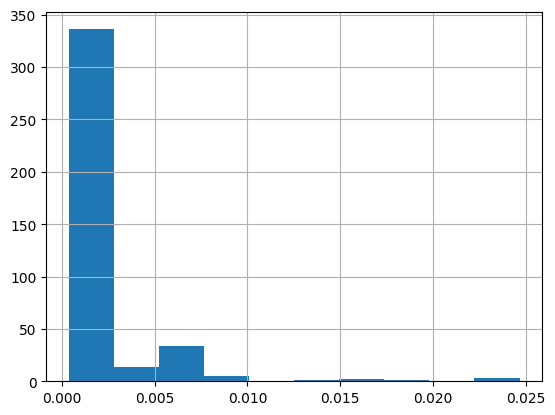

In [116]:
pd.Series(y_pred_test_voli_s).hist()

In [117]:
def calculate_directional_accuracy(actual_values, forecast_values):
    correct_direction = 0
    for i in range(1, len(actual_values)):
        if (actual_values[i] - actual_values[i-1]) * (forecast_values[i] - actual_values[i-1]) > 0:
            correct_direction += 1
    directional_accuracy = correct_direction / (len(actual_values)-1)
    return directional_accuracy
calculate_directional_accuracy(y_test_voli,y_pred_test_voli_s)

0.9063291139240506

In [118]:
def w__Random_forest(y_pred_test,y_pred_test_voli):


  gama = 4
  w_RF = []
  Mkt_Rf = pd.Series(y_pred_test)
  Volatility = pd.Series(y_pred_test_voli)
  for i in range(len(Mkt_Rf)):

    w_RF.append((Mkt_Rf[i]/(4*y_pred_test_voli[i])))
  w_RF = pd.Series(w_RF)
  return w_RF

w_RF = w__Random_forest(y_pred_test,y_pred_test_voli)
w_RF

0       [3.9206917993220283]
1      [-1.3604984440644021]
2       [2.4320151006364594]
3        [3.572539984084999]
4         [4.85515641346574]
               ...          
391      [3.080103562299852]
392     [1.3337266699210335]
393        [3.7772537443628]
394     [3.4442676426315293]
395     [0.6823423521845599]
Length: 396, dtype: object

In [119]:
w_RF_s = []
import matplotlib.pyplot as plt
for k in range(len(w_RF)):
  w_RF_s.append(w_RF[k][0])

for i in range(len(w_RF_s)):
  if w_RF_s[i] > 1:
    w_RF_s[i] = 1
  elif w_RF_s[i]<0:
    w_RF_s[i] = 0

w_RF_s

[1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0.5683387139228969,
 1,
 1,
 0,
 0,
 0.045699068893304044,
 0,
 1,
 1,
 1,
 0,
 1,
 0.5146127892686204,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0.7536475484005927,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0.29025473848189803,
 0,
 1,
 0.3093459490918954,
 0,
 0.5739869121382769,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0.9803411705275833,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0.2794744860784068,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0.8315928302633301,
 0.024731759501577005,
 0.3045672184309975,
 0,
 1,
 0.8514715778504376,
 1,
 0,
 1,
 1,
 0,
 0.1648885122438108,
 0.728897067303754,
 0.7064443205047207,
 1,
 0.14089393960150118,
 0.7908574447519923,
 0.23335968938134247,
 0.24445437880056894,
 1,
 0.2843891087275285,
 0,
 0,
 1,
 1,
 1,
 0.6764434487058056,
 0.22383296030954122,
 1,
 0.5376960998310271,
 0.59641

In [120]:

Final_df = pd.merge(Predictore_df,FF_monthly_df, left_on='Year_Month', right_on='Year_Month', how='inner')
Final_df = Final_df.drop(['Mkt-RF_y','SMB','HML'],axis = 1)
Final_df ['MKT'] = Final_df ['Mkt-RF_x'] + Final_df['RF']
Final_df=Final_df [Final_df['Year_Month']>='198901']
#w_RF_s = pd.DataFrame(w_RF)

Final_df ['w_RF'] = w_RF_s
Final_df

,Year_Month,d/p,e/p,bm,ntis,tbl,ltr,dfy,tms,infl,corpr,svar,lag_ex_ret,Mkt-RF_x,RF,MKT,w_RF
743,198901,-3.409163,-2.510892,0.430769,-0.022361,0.0827,0.0203,0.0103,-0.0624,0.004979,0.0202,0.000965,0.0149,0.0610,0.0055,0.0665,1.000000
744,198902,-3.370986,-2.464957,0.446778,-0.024823,0.0853,-0.0179,0.0097,-0.1032,0.004129,-0.0129,0.001176,0.0610,-0.0225,0.0061,-0.0164,0.000000
745,198903,-3.382850,-2.469260,0.468691,-0.023102,0.0882,0.0122,0.0087,-0.0760,0.005757,0.0064,0.001286,-0.0225,0.0157,0.0067,0.0224,1.000000
746,198904,-3.419909,-2.514668,0.444435,-0.022802,0.0865,0.0159,0.0082,-0.0706,0.006541,0.0213,0.000956,0.0157,0.0433,0.0067,0.0500,1.000000
747,198905,-3.442765,-2.545751,0.433442,-0.027714,0.0843,0.0401,0.0089,-0.0442,0.005686,0.0379,0.001073,0.0433,0.0335,0.0079,0.0414,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1134,202108,-4.342866,-3.282043,0.184756,0.014846,0.0005,-0.0035,0.0069,-0.0040,0.002066,-0.0045,0.000602,0.0127,0.0291,0.0000,0.0291,1.000000
1135,202109,-4.286281,-3.201224,0.193036,0.015598,0.0004,-0.0250,0.0070,-0.0254,0.002716,-0.0194,0.001393,0.0291,-0.0437,0.0000,-0.0437,1.000000
1136,202110,-4.346731,-3.226260,0.182389,0.013368,0.0005,0.0051,0.0067,0.0046,0.008308,0.0159,0.001151,-0.0437,0.0665,0.0000,0.0665,1.000000
1137,202111,-4.331997,-3.177747,0.189455,0.015640,0.0005,0.0210,0.0066,0.0205,0.004913,0.0094,0.001327,0.0665,-0.0155,0.0000,-0.0155,1.000000


In [121]:
Final_df['return'] = (Final_df['MKT'] * Final_df['w_RF']) + ((1-Final_df['w_RF']) * Final_df['RF'])
Final_df

,Year_Month,d/p,e/p,bm,ntis,tbl,ltr,dfy,tms,infl,corpr,svar,lag_ex_ret,Mkt-RF_x,RF,MKT,w_RF,return
743,198901,-3.409163,-2.510892,0.430769,-0.022361,0.0827,0.0203,0.0103,-0.0624,0.004979,0.0202,0.000965,0.0149,0.0610,0.0055,0.0665,1.000000,0.066500
744,198902,-3.370986,-2.464957,0.446778,-0.024823,0.0853,-0.0179,0.0097,-0.1032,0.004129,-0.0129,0.001176,0.0610,-0.0225,0.0061,-0.0164,0.000000,0.006100
745,198903,-3.382850,-2.469260,0.468691,-0.023102,0.0882,0.0122,0.0087,-0.0760,0.005757,0.0064,0.001286,-0.0225,0.0157,0.0067,0.0224,1.000000,0.022400
746,198904,-3.419909,-2.514668,0.444435,-0.022802,0.0865,0.0159,0.0082,-0.0706,0.006541,0.0213,0.000956,0.0157,0.0433,0.0067,0.0500,1.000000,0.050000
747,198905,-3.442765,-2.545751,0.433442,-0.027714,0.0843,0.0401,0.0089,-0.0442,0.005686,0.0379,0.001073,0.0433,0.0335,0.0079,0.0414,1.000000,0.041400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1134,202108,-4.342866,-3.282043,0.184756,0.014846,0.0005,-0.0035,0.0069,-0.0040,0.002066,-0.0045,0.000602,0.0127,0.0291,0.0000,0.0291,1.000000,0.029100
1135,202109,-4.286281,-3.201224,0.193036,0.015598,0.0004,-0.0250,0.0070,-0.0254,0.002716,-0.0194,0.001393,0.0291,-0.0437,0.0000,-0.0437,1.000000,-0.043700
1136,202110,-4.346731,-3.226260,0.182389,0.013368,0.0005,0.0051,0.0067,0.0046,0.008308,0.0159,0.001151,-0.0437,0.0665,0.0000,0.0665,1.000000,0.066500
1137,202111,-4.331997,-3.177747,0.189455,0.015640,0.0005,0.0210,0.0066,0.0205,0.004913,0.0094,0.001327,0.0665,-0.0155,0.0000,-0.0155,1.000000,-0.015500


In [78]:
Final_df.to_csv('finalDF16.csv', index=False)

# Volatility accuracy 